In [152]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import catboost as cb
from catboost import CatBoostClassifier, Pool
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import scipy.sparse as sp
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import BaggingClassifier
%matplotlib inline


In [153]:
df1 = pd.read_csv('Lending_Club_modelling_data_part1.txt', delimiter='\t')
df2 = pd.read_csv('Lending_Club_modelling_data_part2.txt', delimiter='\t', dtype={'column_name': str}, low_memory=False)
df3 = pd.read_csv('Lending_Club_modelling_data_part3.txt', delimiter='\t')
df4 = pd.read_csv('Lending_Club_modelling_data_part4.txt', delimiter='\t')

#merged data
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
print("Before dropping na: ",df.shape)

# Drop the title column because it is the same information as purpose
df = df.drop('title', axis=1)

# Drop application_type, pub_rec, address, initial_list_status, pub_rec_bankruptcies columns since they are useless after checking catboost feature importance
#df = df.drop(['application_type', 'pub_rec', 'address', 'initial_list_status', 'pub_rec_bankruptcies'], axis=1)

# Fill missing values in 'address' column with the wrong address in mort_acc column
df['address'] = df['address'].fillna( '76093 Nicole Parks\r\nEast Donaldfurt, IN 70466')

# Replace missing values in 'emp_title' column with 'Unknown'
df['emp_title'] = df['emp_title'].fillna('Unknown')

# Try dropping employmeny title column
#df = df.drop('emp_title', axis=1)

#print rows with missing values, show only if different from 0
print(df.isnull().sum()[df.isnull().sum() > 0])

#replace target variable values with 0 and 1
df['loan_status'] = df['loan_status'].replace({'Charged Off': 1, 'Fully Paid': 0})

# Convert 'issue_d' column to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# Replace values in 'emp_length' column with numerical values
emp_length_map = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,
    '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10
}
df['emp_length'] = df['emp_length'].replace(emp_length_map)

# Correct types of columns
df['revol_util'] = df['revol_util'].replace({'f':'NaN'})
df['revol_util'] = df['revol_util'].astype(float)
df['total_acc'] = df['revol_util'].replace({'INDIVIDUAL':'NaN'})
df['total_acc'] = df['total_acc'].astype(float)
df['mort_acc'] = df['mort_acc'].replace({'76093 Nicole Parks\r\nEast Donaldfurt, IN 70466':'NaN'})
df['mort_acc'] = df['mort_acc'].astype(float)


Before dropping na:  (396030, 25)
emp_length              18301
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      536
dtype: int64


# Net Profit function

In [154]:
# Define the net_profit function 
def net_profit(y_pred, df):
    # Extract relevant columns from DataFrame as NumPy arrays
    loan_amnt = df['loan_amnt'].values
    int_rate = df['int_rate'].values
    loan_status = df['loan_status'].values
    
    # Who received loans with the model
    index = (y_pred == 0)
    # Who paid back the loans
    index_payback = (loan_status == 0)
    # Who defaulted on the loans
    index_default = (loan_status == 1)
    
    # Calculate profit for loans that were paid back
    paid_back_loans = index & index_payback
    profit_paid_back = loan_amnt[paid_back_loans] * (int_rate[paid_back_loans] / 100)
    total_profit = np.sum(profit_paid_back)
    
    # Calculate loss for loans that defaulted
    defaulted_loans = index & index_default
    loss_defaulted = loan_amnt[defaulted_loans] * 0.5
    total_loss = np.sum(loss_defaulted)
    
    return total_profit - total_loss

# second net profit function with installments

In [155]:
# Define the net_profit function 
def net_profit2(y_pred, df):
    # Extract relevant columns from DataFrame as NumPy arrays
    loan_amnt = df['loan_amnt'].values
    installment = df['installment'].values
    term = df['term'].replace({-1: 36, 1: 60}).values
    loan_status = df['loan_status'].values
    
    # Who received loans with the model
    index = (y_pred == 0)
    # Who paid back the loans
    index_payback = (loan_status == 0)
    # Who defaulted on the loans
    index_default = (loan_status == 1)
    
    # Calculate profit for loans that were paid back
    paid_back_loans = index & index_payback
    profit_paid_back = installment[paid_back_loans]*term[paid_back_loans]-loan_amnt[paid_back_loans]
    total_profit = np.sum(profit_paid_back)
    
    # Calculate loss for loans that defaulted
    defaulted_loans = index & index_default
    loss_defaulted = loan_amnt[defaulted_loans] * 0.5 #paid back %50 of the loan before defalting (assumption)
    total_loss = np.sum(loss_defaulted)
    
    return total_profit - total_loss
    #return total_profit,total_loss,total_profit - total_loss

# Preprocessing

In [156]:
# Convert 'issue_d' column to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# -----------------------------------------------------

# Feature Engineering

In [157]:
df_original=df.copy()
# Separate the data into three groups based on the year ranges
original_training_set = df_original[df_original['issue_d'].dt.year < 2015]
original_validation_set = df_original[df_original['issue_d'].dt.year == 2015]
original_test_set = df_original[df_original['issue_d'].dt.year == 2016]

# Optionally, you may want to reset the index for each subset
original_training_set.reset_index(drop=True, inplace=True)
original_validation_set.reset_index(drop=True, inplace=True)
original_test_set.reset_index(drop=True, inplace=True)

In [158]:
# df['annual_inc']=df['annual_inc']/12 #convert annual income to monthly income
# df['installment_over_income'] = df['installment'] / df['annual_inc']
# df['installment_over_income'] = df['installment_over_income'].replace([np.inf, -np.inf], np.nan)
# df.drop('installment', axis=1, inplace=True) #drop this column as it is redundant
# df.drop('int_rate', axis=1, inplace=True) #redundant
# df.drop('loan_amnt', axis=1, inplace=True)
# df.drop('annual_inc', axis=1, inplace=True) #drop this column as it is redundant



# -----------------------------------------------------

In [159]:

# Convert term to float
df['term'] = df['term'].str.replace(' months', '').astype(float)

# Separate the data into three groups based on the year ranges
training_set = df[df['issue_d'].dt.year < 2015]
validation_set = df[df['issue_d'].dt.year == 2015]
test_set = df[df['issue_d'].dt.year == 2016]


# Try dropping the issue date column from each set as it might fail to generalize
training_set = training_set.drop('issue_d', axis=1)
validation_set = validation_set.drop('issue_d', axis=1)
test_set = test_set.drop('issue_d', axis=1)

# Optionally, you may want to reset the index for each subset
training_set.reset_index(drop=True, inplace=True)
validation_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

# Print the number of rows in each group
print("Number of rows in training set:", len(training_set))
print("Number of rows in validation set:", len(validation_set))
print("Number of rows in test set:", len(test_set))

Number of rows in training set: 273678
Number of rows in validation set: 94264
Number of rows in test set: 28088


We use the iterative imputer now that the only missing values are numerical. First we train the iterative imputer with the training_set to fill the training set. Then the same imputer will be used to fill the validation and the test set. 

In [160]:
print("Missing values in the training set:")
print(training_set.isnull().sum()[training_set.isnull().sum() > 0])

Missing values in the training set:
emp_length              11597
revol_util                208
total_acc                 208
mort_acc                37796
pub_rec_bankruptcies      536
dtype: int64


In [161]:
categorical_columns = training_set.select_dtypes(include='object').columns.tolist()
print(categorical_columns)
numerical_columns = training_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_columns)
print(len(numerical_columns)+len(categorical_columns))

['emp_title', 'home_ownership', 'verification_status', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address']
['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'loan_status', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
23


In [162]:
num_training_set = training_set[numerical_columns].drop('loan_status', axis=1)
numerical_columns_without_loan_status= num_training_set.columns
imputer = IterativeImputer(random_state=0)
imputer.fit(num_training_set)

imputed_array = imputer.transform(num_training_set[numerical_columns_without_loan_status])
num_training_set = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)

# Concatenate imputed features with target variable
training_set[numerical_columns_without_loan_status] = num_training_set

# Check for missing values in the training set
print("Missing values in the training set:")
print(training_set.isnull().sum()[training_set.isnull().sum() > 0])

Missing values in the training set:
Series([], dtype: int64)


REMARK: catboost works as good even without the imputer

# Model

Apply cat boost on the entire training set. Don't need to preprocess because it can handle categorical data really well, just need to specify it. Also scaling is irrelevant because it works like a tree in that sense. 

In [163]:
categorical_columns = training_set.select_dtypes(include='object').columns.tolist()

# Split features and target
X_train = training_set.drop("loan_status", axis=1)
y_train = training_set["loan_status"]

# Initialize CatBoost classifier
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='Logloss',
                           scale_pos_weight=3, 
                           l2_leaf_reg=2,
                           #random_strength=6,
                           verbose=False)

# Fit model
model.fit(X_train, y_train,cat_features=categorical_columns)

# Predictions
y_pred = model.predict(X_train)

Here scaling is important. With 2 i get higher accuracy in the validation set but 0.5 false positive rate (almost overfitting the training set). With 3 or 4 i get a result similar to logistic regression with 3 having higher accuracy but also higher false positive rate.

Profit improvement in the training set

In [164]:
print(original_training_set.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address'],
      dtype='object')


In [165]:
# net profit of the model
net_train_profit_model=net_profit(y_pred,original_training_set)
print("Net profit:", net_train_profit_model)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(original_training_set))
net_train_profit=net_profit(zeros,original_training_set)
print("Net profit original:", net_train_profit)

improved_profit=net_train_profit_model-net_train_profit
print("Improved profit:", improved_profit)

Net profit: 363841764.8850001
Net profit original: 33980007.84500003
Improved profit: 329861757.0400001


Performance on the training set (I OVERFIT!!)

In [166]:
# Confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Evaluate model
print("Training set: ")
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_train, y_pred))

TN, FP, FN, TP = conf_matrix.ravel()

true_negative_rate = TN / (TN + FP)
true_positive_rate = TP / (TP + FN)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)

# true_positives = np.sum((y_train == 1) & (y_pred == 1))
# false_positives = np.sum((y_train == 0) & (y_pred == 1)) 
# false_negatives = np.sum((y_train == 1) & (y_pred == 0))
# true_negatives = np.sum((y_train == 0) & (y_pred == 0))   

# true_negative_rate = true_negatives / (true_negatives + false_positives)
# true_positive_rate = true_positives / (true_positives + false_negatives)
# print("True Negative Rate (non default as non default):", true_negative_rate)
# print("True Positive Rate (default as default):", true_positive_rate)
# print(f"Confusion Matrix:\n{conf_matrix}")

Training set: 
Accuracy: 0.963877257214683
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    223166
           1       0.89      0.92      0.90     50512

    accuracy                           0.96    273678
   macro avg       0.93      0.95      0.94    273678
weighted avg       0.96      0.96      0.96    273678

True Negative Rate (non default as non default): 0.9736653432870599
True Positive Rate (default as default): 0.920632720937599


REMARK: overfitting decerased when i dropped the columns that had the least effect. I also have slightly better accuracy (higher true and false positive) in the validation set but results are still really similar to those of the logistic regression. 

In [167]:
# Get feature importances
feature_importances = model.get_feature_importance()

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                 Feature  Importance
2               int_rate   19.133199
7             annual_inc    9.481402
11      earliest_cr_line    7.206621
10                   dti    6.740871
14             revol_bal    6.730044
4              emp_title    6.672627
3            installment    5.398435
0              loan_amnt    4.927501
12              open_acc    4.747205
19              mort_acc    4.565498
1                   term    4.258903
15            revol_util    4.038923
5             emp_length    3.078359
9                purpose    2.935546
6         home_ownership    2.382157
8    verification_status    2.341492
16             total_acc    1.512990
17   initial_list_status    1.333279
20  pub_rec_bankruptcies    0.993302
13               pub_rec    0.810053
21               address    0.711595
18      application_type    0.000000


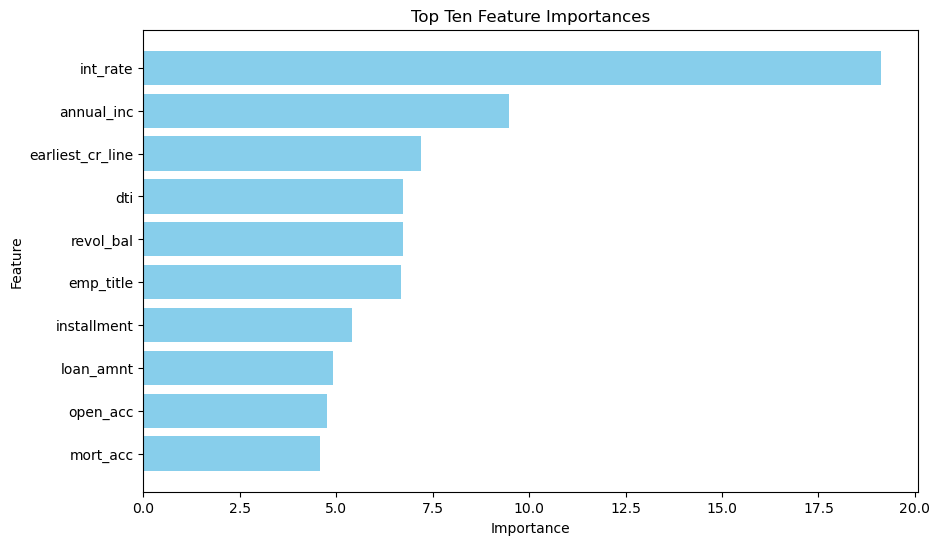

In [168]:
# Sort the dataframe by Importance and select the top ten features
top_features = importance_df.nlargest(10, 'Importance')

# Plotting the top ten features and their importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Ten Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features on top
plt.show()

Check performance on the validation set.

In [169]:
X_val = validation_set.drop("loan_status", axis=1)
y_val = validation_set["loan_status"]

# Impute missing values in the validation set
imputed_array = imputer.transform(X_val[numerical_columns_without_loan_status])
intermediate = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)
X_val[numerical_columns_without_loan_status] = intermediate

# Predictions
y_pred_val = model.predict(X_val)

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

# Evaluate model
print("Validation set: ")
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_val, y_pred_val))

TN, FP, FN, TP = conf_matrix.ravel()

true_negative_rate = TN / (TN + FP)
true_positive_rate = TP / (TP + FN)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)

# true_negatives = np.sum((y_val == 1) & (y_pred_val == 1))
# false_negatives = np.sum((y_val == 0) & (y_pred_val == 1))
# true_positives = np.sum((y_val == 0) & (y_pred_val == 0))   
# false_positives = np.sum((y_val == 1) & (y_pred_val == 0)) #important!

# true_positive_rate = true_positives / (true_positives + false_negatives)
# false_positive_rate = false_positives / (false_positives + true_negatives)
# print("True Positive Rate:", true_positive_rate)
# print("False Positive Rate:", false_positive_rate)
# print(f"Confusion Matrix:\n{conf_matrix}")

Validation set: 
Accuracy: 0.7055715861834847
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     70791
           1       0.43      0.54      0.48     23473

    accuracy                           0.71     94264
   macro avg       0.63      0.65      0.64     94264
weighted avg       0.73      0.71      0.72     94264

True Negative Rate (non default as non default): 0.7590512918308825
True Positive Rate (default as default): 0.5442849231031398


profit improvement of the model in the validation set 

In [170]:
# net profit of the model
net_val_profit_model=net_profit(y_pred_val,original_validation_set)
print("Net profit:", net_val_profit_model)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(original_validation_set))
net_val_profit=net_profit(zeros,original_validation_set)
print("Net profit original:", net_val_profit)

improved_profit=net_val_profit_model-net_val_profit
print("Improved profit:", improved_profit)

Net profit: 8283324.732500002
Net profit original: -48272015.629999995
Improved profit: 56555340.3625


In [171]:
# Predict class probabilities for test data
probabilities = model.predict_proba(X_val)
# probabilities will be a 2D array of shape (n_samples, n_classes)
# Each row corresponds to an observation/sample, and each column corresponds to a class
print(probabilities)

[[0.56075419 0.43924581]
 [0.71710872 0.28289128]
 [0.65298263 0.34701737]
 ...
 [0.75679971 0.24320029]
 [0.46430621 0.53569379]
 [0.72360586 0.27639414]]


# Test Set

In [172]:
X_test = test_set.drop("loan_status", axis=1)
y_test = test_set["loan_status"]

# Impute missing values in the validation set
imputed_array = imputer.transform(X_test[numerical_columns_without_loan_status])
intermediate = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)
X_test[numerical_columns_without_loan_status] = intermediate

# Predictions
y_pred_test = model.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Evaluate model
print("Test set: ")
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

TN, FP, FN, TP = conf_matrix.ravel()

true_negative_rate = TN / (TN + FP)
true_positive_rate = TP / (TP + FN)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)

Test set: 
Accuracy: 0.7121902591854172
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82     24400
           1       0.24      0.55      0.33      3688

    accuracy                           0.71     28088
   macro avg       0.58      0.64      0.57     28088
weighted avg       0.83      0.71      0.75     28088

True Negative Rate (non default as non default): 0.737172131147541
True Positive Rate (default as default): 0.5469088937093276


Net profit improvement in the test set

In [173]:
# net profit of the model
net_test_profit_model=net_profit(y_pred_test,original_test_set)
print("Net profit:", net_test_profit_model)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(original_test_set))
net_test_profit=net_profit(zeros,original_test_set)
print("Net profit original:", net_test_profit)

improved_profit=net_test_profit_model-net_test_profit
print("Improved profit:", improved_profit)

Net profit: 15856269.904999997
Net profit original: 20667631.3575
Improved profit: -4811361.452500004
